In [9]:
from scipy import signal
import numpy as np
import pandas as pd
import bisect
import importlib
import warnings
from pathlib import Path
import gc

import ete3
np.random.seed(7)

Plotting setup:

In [10]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Monospace font for numbers in tables:

In [11]:
%%html
<style> table { font-variant-numeric: tabular-nums; } </style>

## Data dir

In [12]:
data_path = Path('/project/Birds/faststorage/data')
results_path = Path('/project/Birds/faststorage/people/kmt/results')

## "Relative GC* signatures" of Zebra finch hotspot usage

We recorded the relative GC* in the 1kb center of hotspots compared to the 40kb left and right flanks of hotspots for each species. For each hotspot these values were averaged across species, sorted in descending order, and used to sort the hotspots of each species in the same order. For each species, a rolling average across 500 hotspots was applied to obtain the smoothed ‘signature’ of hotspot usage.

So left part is sharing of most commonly used hotspots, right part is sharing of least commonly used hotspots.

In [14]:
signatures = (pd.read_csv('../signatures/signatures.txt', sep=' ').drop(["HALAL", "HALLE"], axis=1).reset_index()
              .melt(id_vars=['index'], var_name='species')
             )
signatures['species'] = pd.Categorical(signatures.species, 
                                       categories=signatures.species.unique().sort(), ordered=True)

In [15]:
species_details = pd.read_table('/home/kmt/Birds/faststorage/data/species_details.txt')

signatures['species_code'] = signatures.species
name_mapping = dict(zip(species_details.species2014, species_details.english))

signatures['species'] = [name_mapping[x] for x in signatures.species_code]

signatures['species'] = pd.Categorical(signatures.species, 
                                       categories=signatures.species.unique().sort(), ordered=True)

In [16]:
signatures.species.unique().size

46

Plot to go in the main paper:

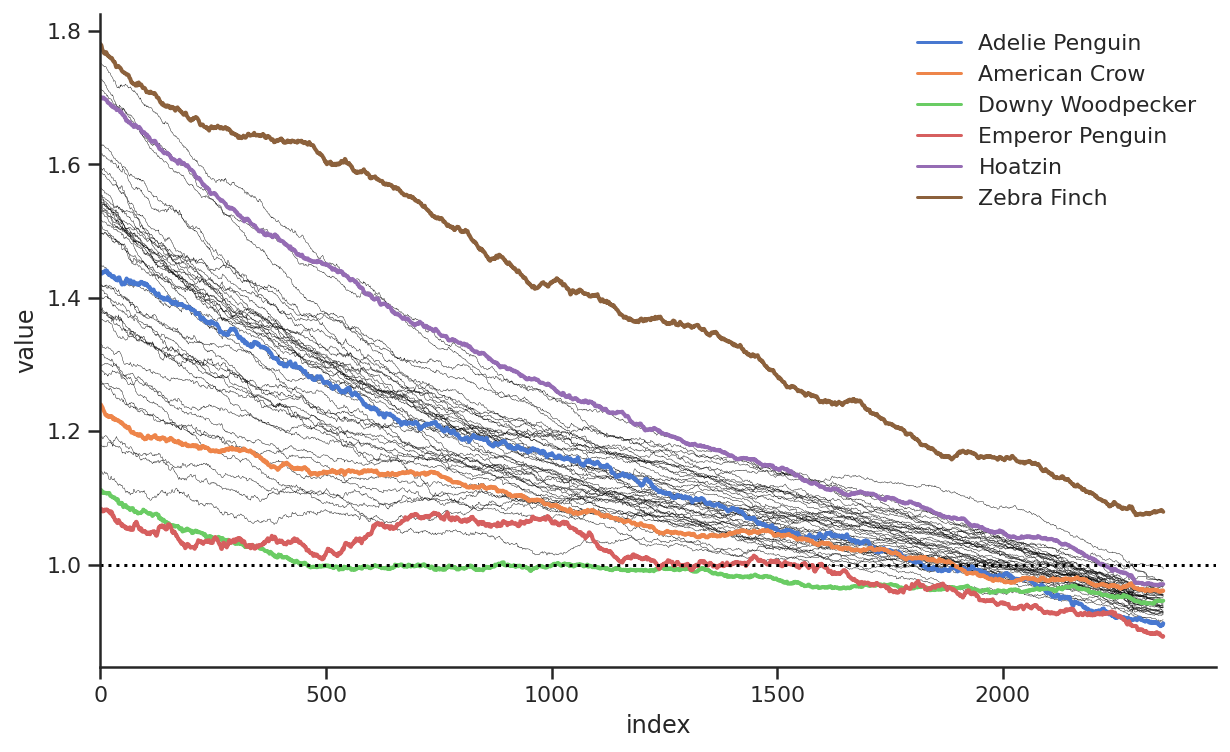

In [42]:
plot_df = signatures.copy().loc[signatures.species_code.isin(['TAEGU', 'PICPU', 'OPHHO', 'APTFO', 'PYGAD', 'CORBR'])]
# plot_df.species.cat.remove_unused_categories(inplace=True)
plot_df['species'] = plot_df['species'].cat.remove_unused_categories()
#with sns.color_palette("colorblind"):
with sns.color_palette("muted"):
    with sns.axes_style('ticks'):
        plt.figure(figsize=(10, 6))
        sns.lineplot(x='index', y='value', hue='species', data=signatures, 
                     palette=sns.color_palette(['#000000']*signatures.species.unique().size),
    #                  palette='Greys', 
                     linewidth=0.2,
                     legend=False, zorder=0, ci=None)
        sns.lineplot(x='index', y='value', hue='species', 
                     data=plot_df, 
                     linewidth=2,
                     ci=None)
        plt.axhline(y=1, linestyle='dotted', color='black')
        sns.despine() 
        plt.legend(frameon=False)#.texts[0].set_text('')
        plt.xlim(left=0)

Substitution rates creates increased GC* in all but four species, which indicates shared hotspots. The signatures of hotspot strengths show no decay with increasing distance to TAEGU, suggesting proportion of shared hotspots are not a function of phylogenetic distance.

Also, the signatures dip below 1 for the hotspots with weakest mean strength, except for Zebra finch. That is expected if a subset of hotspots are unique to Zebra finch. Then a half of those are expected to dip below one by chance.

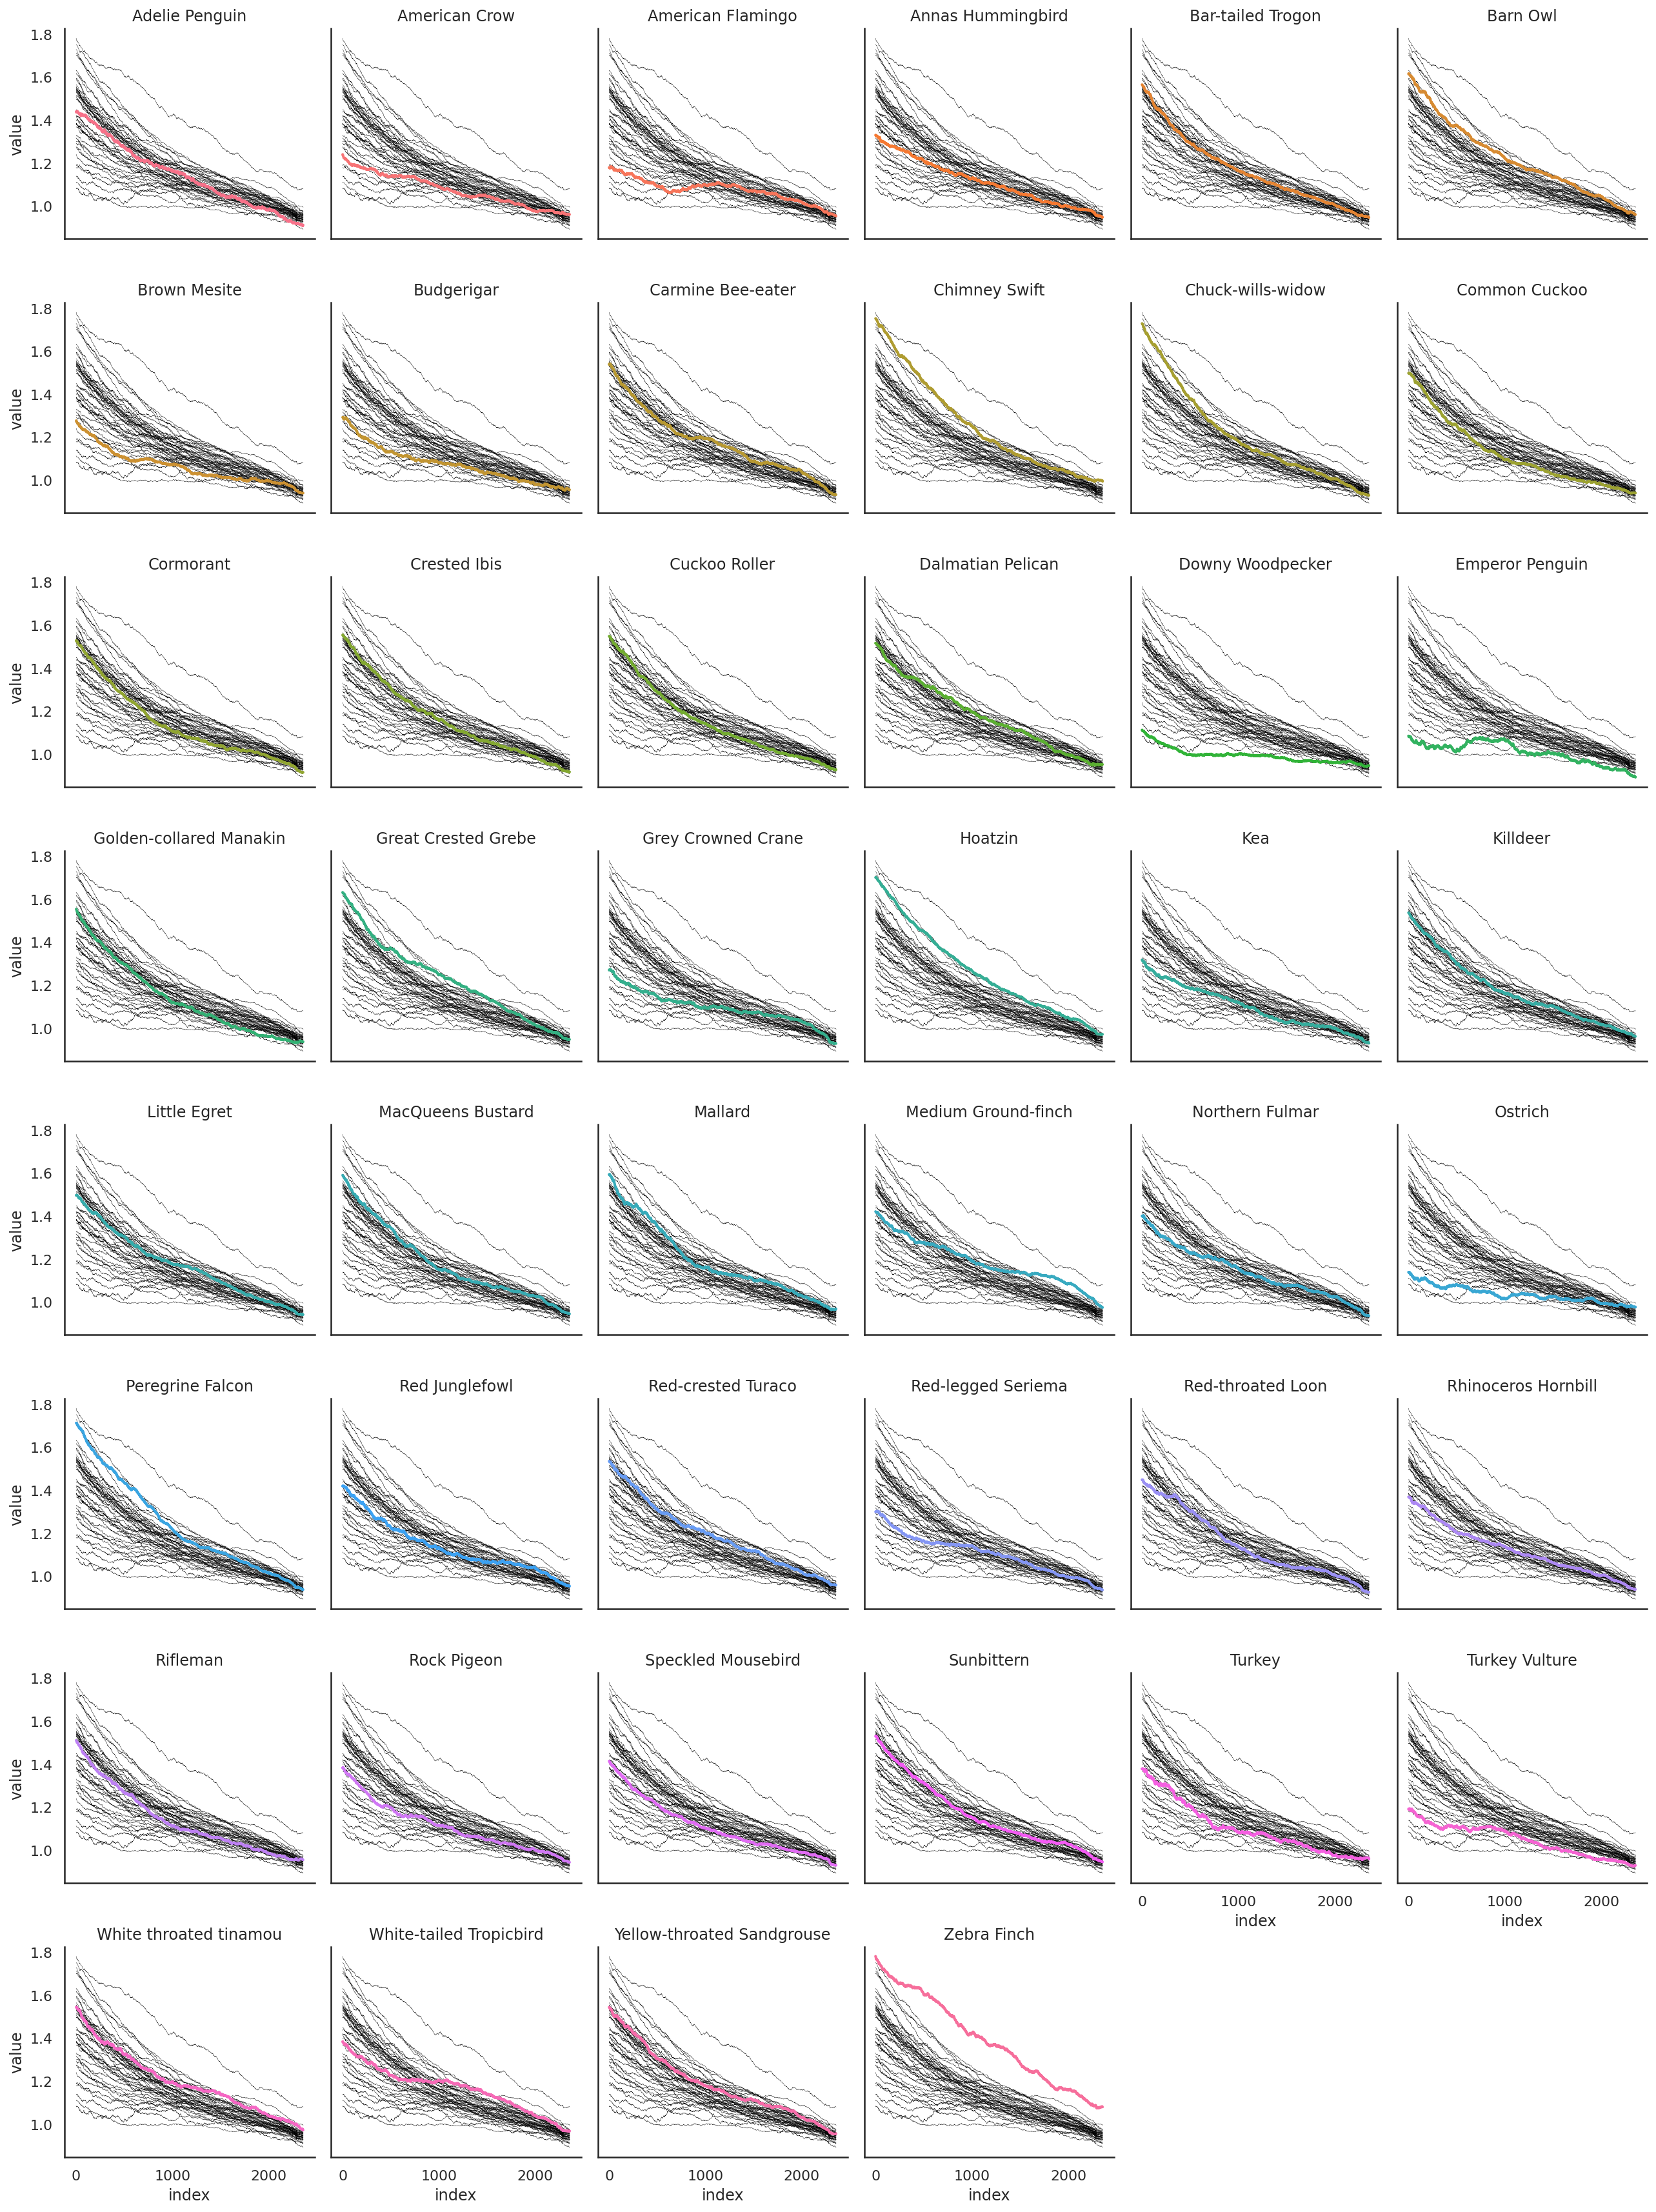

In [43]:
with sns.color_palette("muted"):
    g = sns.FacetGrid(signatures,
                      col='species', hue='species',
                      col_wrap=6, sharey=True)
    g.map(sns.lineplot, 'index', 'value', ci=None, linewidth=2)
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    for ax in g.axes.flat:
        sns.lineplot(x='index', y='value', hue='species', ci=None, 
    #                  palette='Greys',
                     palette=sns.color_palette(['#000000']*signatures.species.unique().size),
                     linewidth=0.2,
                     legend=False, zorder=0, data=signatures, ax=ax)